In [7]:
import pandas as pd
import glob
import os
import pytz

import matplotlib.pyplot as plt
%matplotlib notebook

In [8]:
Glacier='Gulkana'
Station='1480' #gage is 370

In [9]:
if Glacier + Station== "Gulkana1480":
    par_dir=r"Q:\Project Data\GlacierData\Benchmark_Program\Data/" +Glacier+ r'/AllYears/Wx/Raw/telemeteredNWIS'
if Glacier + Station =="Wolverine990":
    par_dir=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1995to2017"
if Glacier + Station=="Wolverine370":
    par_dir=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage"

In [10]:
os.chdir(par_dir)
fls=glob.glob('*.csv')

In [11]:
#Remove the summary file if already made previously
fls.remove("NWIS_data_"+Glacier + Station+".csv")

ValueError: list.remove(x): x not in list

In [12]:
alldat=pd.DataFrame()
for fl in fls:
    dat=pd.read_csv(fl, header=14)
    var_name=fl.replace(".csv", "")
    print(var_name)
    dat=dat[['ISO 8601 UTC', ' Value']]
    dat.rename(columns = {' Value': var_name}, inplace = True)
    if fl==fls[0]:
        alldat=alldat.append(dat)
        continue
    alldat=alldat.merge(dat, on='ISO 8601 UTC', how='outer')

StageCumulative
Tpassive1
Tpassive2
WindDir
WindSpeed


In [13]:
alldat=alldat.rename(columns={'ISO 8601 UTC': "UTC_time"})

In [14]:
#Convert wind gust speed from mph to m/s!! (this is only @ Wolv 990)
if Glacier + Station == 'Wolverine990':
    alldat.WindGustSpeed=alldat.WindGustSpeed * 0.44704 #convert from mph to m/s

In [15]:
#Convert english units to metric @ gage
if Glacier +Station== 'Wolverine370':
    alldat.TipIncremental= alldat.TipIncremental * 0.0254 #convert from inches to meters of precip
    alldat.Discharge=alldat.Discharge * 0.0283168 #convert from ft3/s to m3/s

In [16]:
alldat['UTC_time']=pd.to_datetime(alldat.UTC_time, format='%Y-%m-%dT%H:%M:%SZ')

In [17]:
#Set timezone of known UTC column
alldat['UTC_time'].timezone='UTC'
#Create column for local time
timezone='America/Anchorage'
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

alldat=alldat.set_index('UTC_time')
#Create column for local time
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)

#Re-sort on time index
alldat=alldat.sort_index()

In [18]:
#Determine which years have cumulative precip, and which have incremental.
if Glacier + Station=='Wolverine370':
    alldat['month']=alldat.index.month
    alldat.loc[~alldat.month.isin([6,7,8,9]), 'TipIncremental']=pd.np.nan #first, set non-summer months to NAN
# alldat.loc['2001-01':'2001-08-08', 'TipIncremental']=pd.np.nan #this data looks bad; unknown

# incr_years=['2001', '2002', '2003' '2004']
# cum_years=[]
# bad_yrs=['2009', '2010', '2011']

In [19]:
#Reindex to 15 min (some times are at hourly; fill according to sensor type)
full_range_15_min = pd.date_range(alldat.index[0], alldat.index[-1], freq='15min')
alldat=alldat.reindex(index=full_range_15_min, fill_value=pd.np.nan)
#Create local time
alldat['local_time'] = alldat.index.tz_localize('UTC').tz_convert(local_timezone)

In [25]:
#Wolverine River Stage Stuff
if Glacier + Station== 'Wolverine370':
    alldat[alldat.TipIncremental>1]=pd.np.nan

    #Fill forwards according to data type
    alldat.Tpassive1=alldat.Tpassive1.interpolate(limit=3) #comes as hourly; need to interpolate back to 15 min
    Null_to_keep=alldat.index[alldat.TipIncremental.isnull() & alldat.TipIncremental.shift(1).isnull() &alldat.TipIncremental.shift(-1).isnull()]
    alldat.TipIncremental=alldat.TipIncremental.fillna(value=0)
    alldat.loc[alldat.index.isin(Null_to_keep), 'TipIncremental']=pd.np.nan

    #Set uncertain precip data to NAN (pre 2005)
    alldat.loc[:'2004', 'TipIncremental']=pd.np.nan #Can't tell what is happening with these; huge #s, but don't seem to be simply cumulative? Change in units? Something else? Very hard to say.

    alldat['TipCumulative']=alldat.TipIncremental.cumsum()

    date_format='%Y/%m/%d %H:%M'
    timezone='America/Anchorage'

    #Set output format of time
    alldat['UTC_time']=alldat.index.strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
    alldat['local_time']=alldat.index.strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)

    save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" + Glacier+ r"/AllYears/Wx/LVL0/emily/" + Glacier.lower() + Station+"_15min_all.csv"

    #columns desired in standard output
    out_columns=['UTC_time', 'local_time', 'Tpassive1', 'Tpassive2',
           'TAspirated1', 'TAspirated2', 
           'TipCumulative', 'Discharge']

    #If this columns is not in dataframe, create
    for col in out_columns:
        if col not in alldat.columns:
            alldat[col]=pd.np.nan #create the column; fill with NANs

    save_dat=alldat[out_columns]

    #Ensure data does not have duplicates
    save_dat.drop_duplicates(inplace=True)
    
    #Save to the L0 spot
    save_dat.to_csv(save_pth, index=False, float_format='%g', date_format=date_format)

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [29]:
a='bad'

In [30]:
a != True 

True

In [28]:
#Save File if NOT Wolv370
if Glacier + Station != 'Wolverine370':
save_dat.to_csv("NWIS_data_"+Glacier + Station+".csv", date_format='%Y/%m/%d %H:%M')

In [ ]:
#Other plots and such

<IPython.core.display.Javascript object>


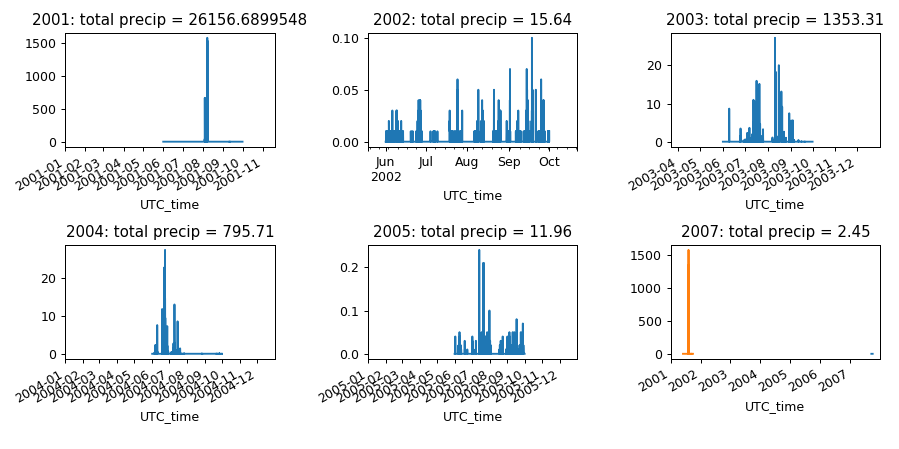

In [44]:
# Using figsize to make the figure a little bigger, 10"x5"
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Doing each of these manually (ugh)
yr='2001'
alldat.TipIncremental[yr].plot(ax=ax1)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2002'
alldat.TipIncremental[yr].plot(ax=ax2)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2003'
alldat.TipIncremental[yr].plot(ax=ax3)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2004'
alldat.TipIncremental[yr].plot(ax=ax4)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2005'
alldat.TipIncremental[yr].plot(ax=ax5)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2007'
alldat.TipIncremental[yr].plot(ax=ax6)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax6.set_title(str(yr)+": total precip = "+ str(total_precip))

# df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# ax2.set_title("Iran")
# df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# ax3.set_title("France")
# df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# ax4.set_title("Ireland")
# df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# ax5.set_title("Kazakhstan")
# df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# ax6.set_title("United Arab Emirates")

# If you don't do tight_layout() you'll have weird overlaps
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2001to2007.jpg') 

In [30]:
alldat.TipIncremental['2005-06-28 18':'2005-06-28 21']

UTC_time
2005-06-28 18:00:00    0.0
2005-06-28 18:15:00    0.0
2005-06-28 18:30:00    0.0
2005-06-28 18:45:00    0.0
2005-06-28 19:00:00    0.0
2005-06-28 19:15:00    0.0
2005-06-28 19:30:00    0.0
2005-06-28 20:15:00    0.0
2005-06-28 20:30:00    0.0
2005-06-28 20:45:00    0.0
2005-06-28 21:00:00    0.0
2005-06-28 21:15:00    0.0
2005-06-28 21:30:00    0.0
2005-06-28 21:45:00    0.0
2005-06-28 19:45:00    0.0
2005-06-28 20:00:00    0.0
Name: TipIncremental, dtype: float64

In [21]:
alldat.loc[alldat.TipIncremental>50, 'TipIncremental']=pd.np.nan

In [22]:
alldat['month']=alldat.index.month
alldat.month.isin([6,7,8,9])
alldat.loc[~alldat.month.isin([6,7,8,9]), 'TipIncremental']=pd.np.nan

In [23]:
#clean_increment=alldat.TipIncremental[alldat.TipIncremental.notnull()]['2002':]

<IPython.core.display.Javascript object>


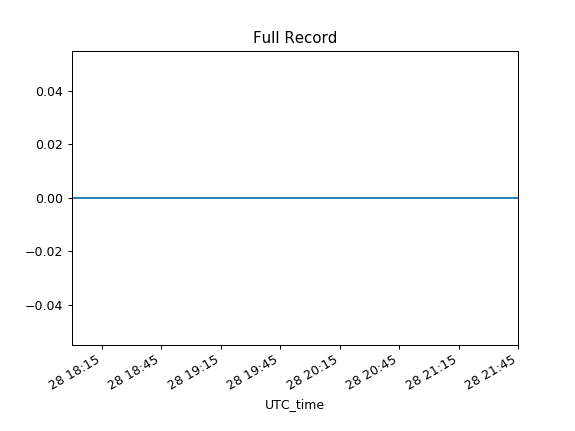

In [32]:
plt.figure()
ax=alldat.TipIncremental['2005-06-28 18':'2005-06-28 21'].cumsum().plot()
#alldat.TipIncremental.cumsum(skipna=True).plot(marker='o', ms=3, color='red', ax=ax)
#plt.legend(['From Cumulative File', 'From Incremental File'])
plt.title("Full Record")

<IPython.core.display.Javascript object>


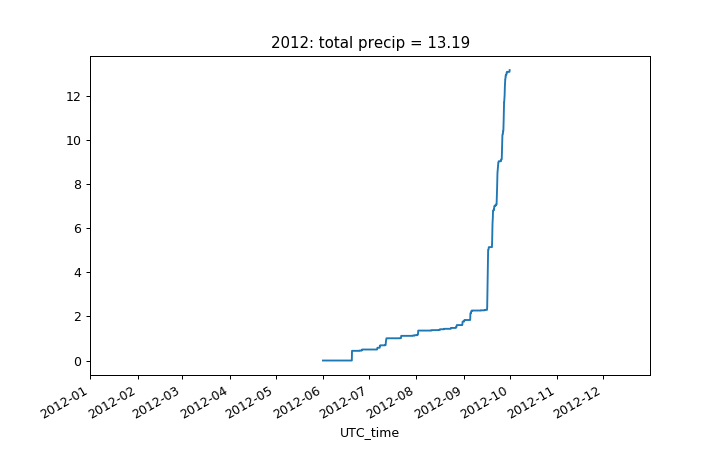

In [62]:
plt.figure()
yr='2012'
alldat.TipIncremental[yr].cumsum().plot()
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
plt.title(str(yr)+": total precip = "+ str(total_precip))

<IPython.core.display.Javascript object>


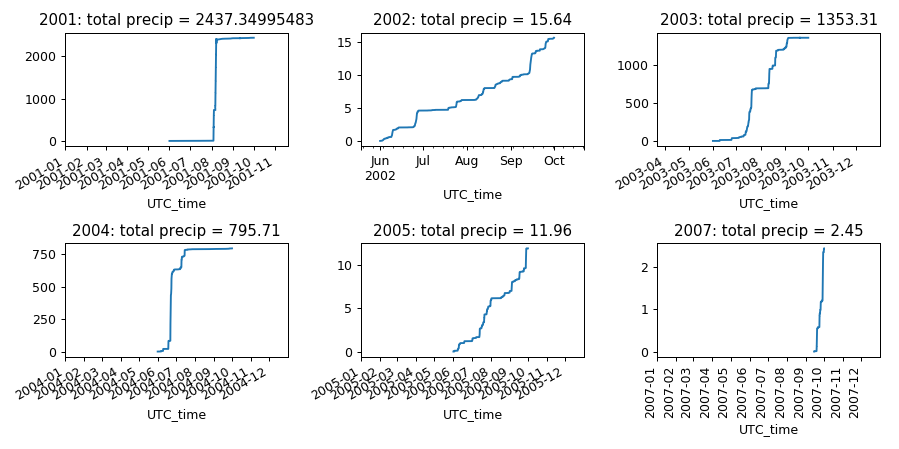

In [108]:
# Using figsize to make the figure a little bigger, 10"x5"
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Doing each of these manually (ugh)
yr='2001'
alldat.TipIncremental[yr].cumsum().plot(ax=ax1)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2002'
alldat.TipIncremental[yr].cumsum().plot(ax=ax2)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2003'
alldat.TipIncremental[yr].cumsum().plot(ax=ax3)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2004'
alldat.TipIncremental[yr].cumsum().plot(ax=ax4)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2005'
alldat.TipIncremental[yr].cumsum().plot(ax=ax5)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2007'
alldat.TipIncremental[yr].cumsum().plot(ax=ax6)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax6.set_title(str(yr)+": total precip = "+ str(total_precip))

# df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# ax2.set_title("Iran")
# df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# ax3.set_title("France")
# df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# ax4.set_title("Ireland")
# df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# ax5.set_title("Kazakhstan")
# df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# ax6.set_title("United Arab Emirates")

# If you don't do tight_layout() you'll have weird overlaps
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2001to2007.jpg') 

<IPython.core.display.Javascript object>


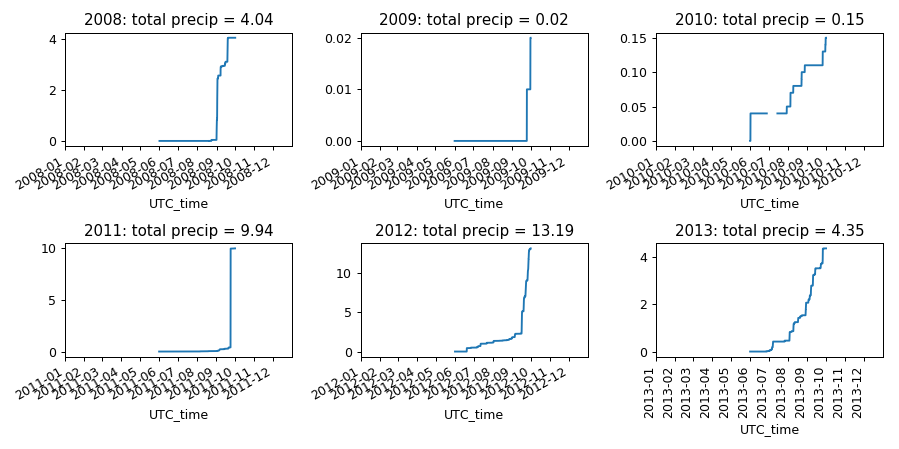

In [109]:
# Using figsize to make the figure a little bigger, 10"x5"
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Doing each of these manually (ugh)
yr='2008'
alldat.TipIncremental[yr].cumsum().plot(ax=ax1)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2009'
alldat.TipIncremental[yr].cumsum().plot(ax=ax2)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2010'
alldat.TipIncremental[yr].cumsum().plot(ax=ax3)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2011'
alldat.TipIncremental[yr].cumsum().plot(ax=ax4)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2012'
alldat.TipIncremental[yr].cumsum().plot(ax=ax5)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2013'
alldat.TipIncremental[yr].cumsum().plot(ax=ax6)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax6.set_title(str(yr)+": total precip = "+ str(total_precip))

# df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# ax2.set_title("Iran")
# df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# ax3.set_title("France")
# df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# ax4.set_title("Ireland")
# df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# ax5.set_title("Kazakhstan")
# df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# ax6.set_title("United Arab Emirates")

# If you don't do tight_layout() you'll have weird overlaps
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2008to2013.jpg') 

<IPython.core.display.Javascript object>


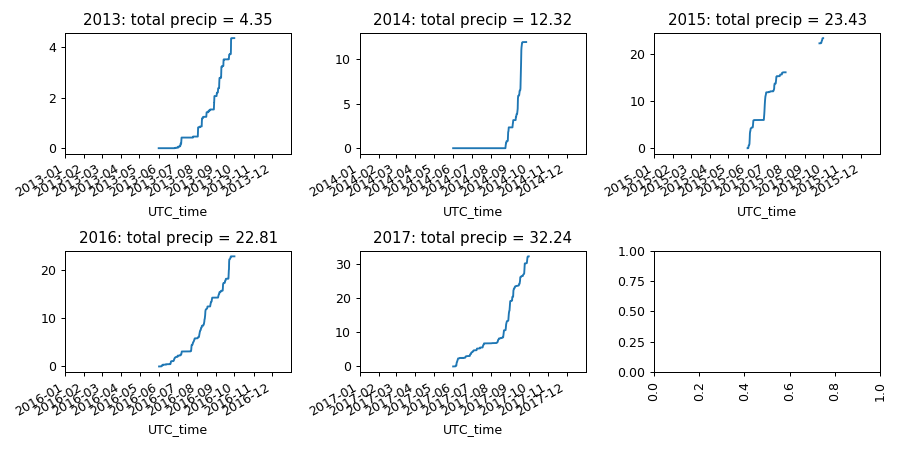

In [110]:
# Using figsize to make the figure a little bigger, 10"x5"
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(10,5))

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

# Doing each of these manually (ugh)
yr='2013'
alldat.TipIncremental[yr].cumsum().plot(ax=ax1)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax1.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2014'
alldat.TipIncremental[yr].cumsum().plot(ax=ax2)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax2.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2015'
alldat.TipIncremental[yr].cumsum().plot(ax=ax3)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax3.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2016'
alldat.TipIncremental[yr].cumsum().plot(ax=ax4)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax4.set_title(str(yr)+": total precip = "+ str(total_precip))

yr='2017'
alldat.TipIncremental[yr].cumsum().plot(ax=ax5)
total_precip=alldat.TipIncremental[yr].cumsum()[alldat.TipIncremental[yr].cumsum().last_valid_index()]
ax5.set_title(str(yr)+": total precip = "+ str(total_precip))

# df[df['Country'] == 'Iran'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax2)
# ax2.set_title("Iran")
# df[df['Country'] == 'France'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax3)
# ax3.set_title("France")
# df[df['Country'] == 'Ireland'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax4)
# ax4.set_title("Ireland")
# df[df['Country'] == 'Kazakhstan'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax5)
# ax5.set_title("Kazakhstan")
# df[df['Country'] == 'United Arab Emirates'].plot(x='Year', y='GDP_per_capita', legend=False, ax=ax6)
# ax6.set_title("United Arab Emirates")

# If you don't do tight_layout() you'll have weird overlaps
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig(r'Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\telemeteredNWIS\Historical_1997to2017StreamGage\rawdataplots2013to2017.jpg') 

<IPython.core.display.Javascript object>


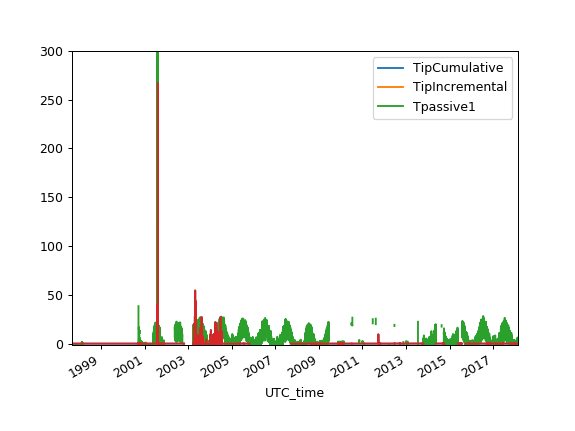

(-1, 300)

In [58]:
alldat[['TipCumulative', 'TipIncremental', 'Tpassive1']].plot()
plt.ylim(-1, 300)

In [23]:
#Remove UTC from index
alldat=alldat.reset_index()

In [24]:
alldat['UTC_time']=alldat.UTC_time.dt.strftime('%Y/%m/%d %H:%M') #set as string in desired format
alldat['local_time']=alldat.local_time.dt.strftime('%Y/%m/%d %H:%M')
alldat.to_csv("NWIS_data_" + Glacier+ Station +".csv", index=False, float_format='%g')

In [25]:
alldat.head(1)

,UTC_time,TipCumulative,TipIncremental,Tpassive1,local_time
0,1997/08/27 13:45,0.0,NaN,NaN,1997/08/27 05:45


In [108]:
dat1=pd.read_csv("Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\Raw\StreamGage\wlca2_2015.csv", infer_datetime_format=True)

In [131]:
dat1.head()

,2015,GMT,GOES,Stage,Flow,Stage.1,Flow.1,P_accum,T_cur,T_water,Bat_vlt
0,wlca2,jan 1 000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.5
1,wlca2,jan 1 000,15.0,2.56,232.0,10.65,NaN,NaN,NaN,NaN,NaN
2,wlca2,jan 1 000,30.0,2.55,230.0,11.39,NaN,40.34,NaN,NaN,NaN
3,wlca2,jan 1 000,45.0,2.54,227.0,11.44,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
precip=dat1.P_accum

In [133]:
precip=precip.reset_index(drop=True)

In [134]:
precip.head(5)

0      NaN
1      NaN
2    40.34
3      NaN
4      NaN
Name: P_accum, dtype: float64

<IPython.core.display.Javascript object>


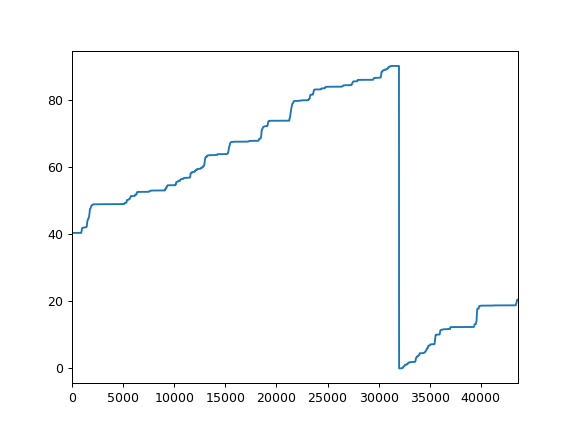

In [136]:
plt.figure()
precip.dropna().plot()

<IPython.core.display.Javascript object>


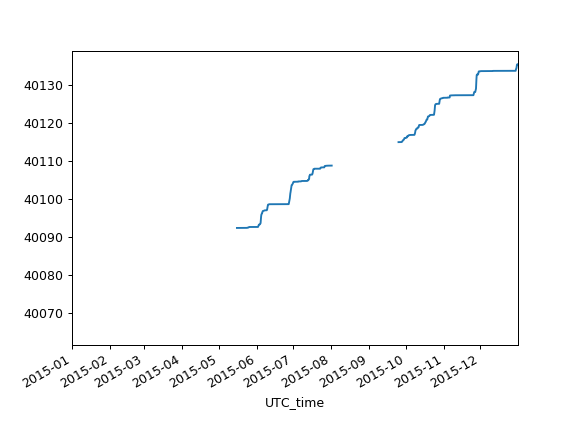

In [126]:
plt.figure()
alldat.TipIncremental.cumsum()['2015'].plot()